In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import MNISTtools as mns
import torch.autograd as ag
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import vgg19
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

from torch.utils.data import Dataset
from PIL import Image
import glob

from scipy.ndimage import convolve


Import dataset

In [2]:
def normalize_MNIST_images(x):
    return np.float64(x)/255.0*2-1
xtrain, ltrain = mns.load(dataset="training", path="/datasets/MNIST")
xtrain = normalize_MNIST_images(xtrain)
xtest, ltest = mns.load(dataset="testing", path="/datasets/MNIST")
xtest = normalize_MNIST_images(xtest)
xtrain = xtrain[:,:100] # Use smaller amounts of data

Reorganize to expected format for cnn

(100, 1, 28, 28)
(100, 1, 14, 14)


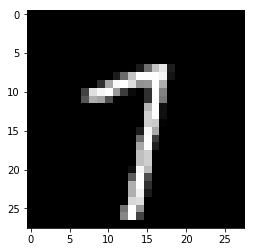

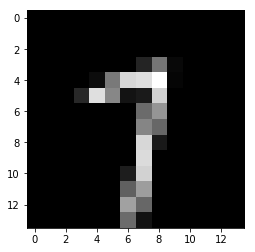

In [3]:
W = 28
H = 28
channels = 1

xtrain = np.moveaxis(xtrain.reshape(W, H, 1, -1), [2,3], [1,0])
xtest = np.moveaxis(xtest.reshape(W, H, 1, -1), [2,3], [1,0])

# Downsample original image by 2
xtrain_hr = xtrain
xtrain_lr = np.empty((xtrain_hr.shape[0], 1, W//2, H//2))
for i in range(xtrain_hr.shape[0]):
    xtrain_lr[i,0,:,:] = convolve(xtrain_hr[i,0,:,:], 
                                  np.array([[0.25,0.25],[0.25,0.25]]))[:xtrain_hr.shape[2]:2,:xtrain_hr.shape[3]:2]
print(xtrain_hr.shape)
print(xtrain_lr.shape)
plt.figure()
plt.imshow(xtrain_hr[42,0,:,:], cmap='gray')
plt.figure()
plt.imshow(xtrain_lr[42,0,:,:], cmap='gray')
plt.show()

In [4]:
xtrain_hr = torch.from_numpy(xtrain_hr)
xtrain_lr = torch.from_numpy(xtrain_lr)
# ltrain = torch.from_numpy(ltrain)
# xtest = torch.from_numpy(xtest)
if torch.cuda.is_available():
    xtrain_hr = xtrain_hr.cuda()
    xtrain_lr = xtrain_lr.cuda()
#     ltrain = ltrain.cuda()
#     xtest = xtest.cuda()
x_hr = ag.Variable(xtrain_hr, requires_grad = True)
x_lr = ag.Variable(xtrain_lr, requires_grad = True)
# ltrain = ag.Variable(ltrain, requires_grad = False)
# xtest = ag.Variable(xtest, requires_grad = False)

Build network

In [5]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

        vgg19_model = vgg19(pretrained=True)

        # Extracts features at the 11th layer
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:12])

    def forward(self, img):
        out = self.feature_extractor(img)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.Conv2d(in_features, in_features, 3, 1, 1),
                        nn.BatchNorm2d(in_features),
                        nn.ReLU(),
                        nn.Conv2d(in_features, in_features, 3, 1, 1),
                        nn.BatchNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=channels, out_channels=channels, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 9, 1, 4),
            nn.ReLU(inplace=True)
        )

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.BatchNorm2d(64))

        # Upsampling layers
        upsampling = []
        for out_features in range(1):
            upsampling += [ nn.Conv2d(64, 256, 3, 1, 1),
                            nn.BatchNorm2d(256),
                            nn.PixelShuffle(upscale_factor=2),
                            nn.ReLU(inplace=True)]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, 9, 1, 4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out

class Discriminator(nn.Module):
    def __init__(self, in_channels=channels):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize):
            """Returns layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for out_filters, stride, normalize in [ (64, 1, False),
                                                (64, 2, True),
                                                (128, 1, True),
                                                (128, 2, True),
                                                (256, 1, True),
                                                (256, 2, True),
                                                (512, 1, True),
                                                (512, 2, True),]:
            layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
            in_filters = out_filters

        # Output layer
        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)


Train network

In [6]:
N = x_hr.size()[0] # Training set size
B = 1 # Minibatch size
NB = (N+B-1)/B # Number of minibatches
T = 10 # Number of epochs
gamma = .001 # learning rate
rho = .9 # momentum
lr = 0.0002 # Adam learning rate
b1 = 0.5 # Adam decay
b2 = 0.999 # Adam decay

cuda = True if torch.cuda.is_available() else False

# Initialize discriminator and generator
generator = GeneratorResNet()
discriminator = Discriminator()
feature_extractor = FeatureExtractor()

# Loses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Adversarial ground truths
valid = Variable(Tensor(np.ones((1,1,2,2))), requires_grad=False)
fake = Variable(Tensor(np.zeros((1,1,2,2))), requires_grad=False)

for epoch in range(T):
    running_loss = 0.0
    idxminibatches = np.random.permutation(NB) # shuffling
    for k in range(NB):
        i = idxminibatches[k] # index of minibatch
        
        # Extract i-th minibatch from xtrain and ltrain
        idxsmp = np.arange(B*i, min(B*(i+1), N)) # indices of samples for i-th minibatch
        inputs_hr = x_hr[idxsmp].float()
        inputs_lr = x_lr[idxsmp].float()
        
        # ------------------
        #  Train Generators
        # ------------------
        
        # Initialize the gradients to zero
        optimizer_G.zero_grad()
        
        # Generate high resolution image
        gen_hr = generator(inputs_lr)
        
        # Adversarial loss
        gen_validity = discriminator(gen_hr)
        loss_GAN = criterion_GAN(gen_validity, valid)
        
        # Content loss
#         gen_features = feature_extractor(gen_hr)
#         real_features = Variable(feature_extractor(inputs_hr).data, requires_grad=False)
#         loss_content =  criterion_content(gen_features, real_features)
        
        # Total loss
        loss_G = 1e-3 * loss_GAN #+ loss_content 
        
        # Back propagation
        loss_G.backward()
        
        # Parameter update
        optimizer_G.step()
        
        # ---------------------
        #  Train discriminator
        # ---------------------
        
        # Initialize the gradients to zero
        optimizer_D.zero_grad()
        
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(inputs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        
        # Total loss
        loss_D = (loss_real + loss_fake)/2
        
        # Back propagation
        loss_D.backward()
        
        # Parameter update
        optimizer_D.step()
        
        # --------------
        #  Log Progress
        # --------------
    print(epoch)

#         print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" %
#                                                             (epoch, T, k, len(dataloader),
#                                                             loss_D.item(), loss_G.item()))
        

print('Finished Training')

0
1
2
3
4
5
6
7
8
9
Finished Training


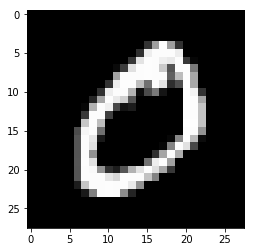

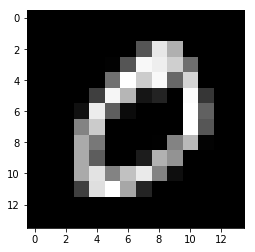

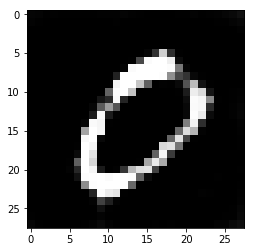

In [39]:
img_n = 1
plt.figure()
plt.imshow(xtrain_hr[img_n,0,:,:], cmap='gray')
plt.figure()
plt.imshow(xtrain_lr[img_n,0,:,:], cmap='gray')

x_up = generator(x_lr[[img_n]].float()).cpu().data.numpy()
plt.figure()
plt.imshow(x_up[0,0,:,:], cmap='gray')